C:\Users\vrnsi\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vrnsi\anaconda3\lib\site-packages\numpy\.libs\libopenblas.fb5ae2tyxyh2ijrdkgdgq3xbklktf43h.gfortran-win_amd64.dll
C:\Users\vrnsi\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


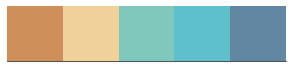

In [1]:
import pandas as pd
import numpy as np
import re
import os
import string
from datetime import datetime
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import STOPWORDS as stopwords_wc
from statsmodels.tsa.stattools import adfuller 

# Set Style
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Color palette
my_colors = ["#ce8f5a", "#efd199", "#80c8bc", "#5ec0ca", "#6287a2"]
sns.palplot(sns.color_palette(my_colors))

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'

In [2]:
def offset_png(x, y, path, ax, zoom, offset):
    '''For adding other .png images to the graph.
    source: https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib'''
    
    img = plt.imread(path)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax
    x_offset = offset
    ab = AnnotationBbox(im, (x, y), xybox=(x_offset, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)
    
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
def emoji_extractor(string, remove=False):
    '''Removes Emoji from a text.'''
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    if remove == False:
        # Extract emoji
        return emoji_pattern.findall(string)
    else:
        # Remove emoji from text
        return emoji_pattern.sub(r'', string)

def clean_emoji(x):
    if len(x) == 0:
        return ''
    else:
        return x[0]
    
    
    
def clean_tweets(df):
    '''Returns the dataframe with the tweet column cleaned.'''
    
    # ----- Remove \n, \t, \xa0 -----
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ''))
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\xa0', ''))
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ''))
    
    # ----- Remove pic.twitter and http:// + https:// links -----
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'https\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'pic.twitter\S+', '', x))
    
    # ----- Remove mentions and hashtags -----
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'#\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@\S+', '', x))
    
    # ----- Extract Emojis and Remove from Tweet -----
    df['tweet_emojis'] = df['tweet'].apply(lambda x: emoji_extractor(x, remove=False))
    df['tweet_emojis'].replace('', np.nan, inplace=True)

    #df["tweet_emojis"] = df["tweet_emojis"].apply(lambda x: clean_emoji(x))
    
    df['tweet'] = df['tweet'].apply(lambda x: emoji_extractor(x, remove=True))
    
    # ----- Strip of whitespaces -----
    df['tweet'] = df['tweet'].apply(lambda x: x.strip())
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x.split()))
    
    # ----- Remove punctuation & Make lowercase -----
    df['tweet'] = df['tweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df['tweet'] = df['tweet'].apply(lambda x: x.lower())
    
    return df

In [3]:
# === Tweets ===
tweets = pd.read_csv("TweetsElonMusk.csv")
tweets = tweets[["id", "date", "time", "username", 
                 "tweet", "mentions", "urls", "photos", "replies_count", 
                 "retweets_count", "likes_count", "hashtags", "link"]]

# Create new features
tweets["year"] = tweets["date"].apply(lambda x: x.split("-")[0])
# Clean Tweets
tweets = clean_tweets(df=tweets)

Tweets shape: (12562, 15) 
Bitcoin shape: (4857377, 8) 



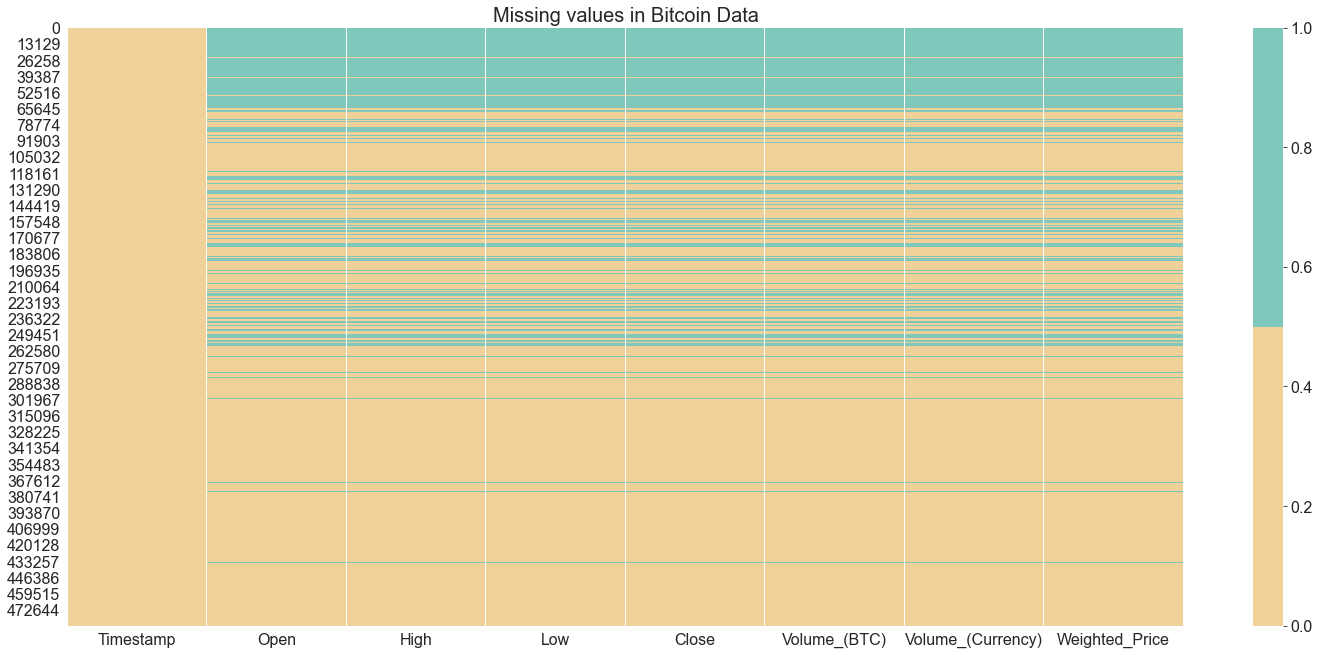

In [4]:
# === Bitcoin ===
bitcoin = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

# Prints
print(color.BOLD + "Tweets shape:" + color.END, "{}".format(tweets.shape), "\n" +
      color.BOLD + "Bitcoin shape:" + color.END, "{}".format(bitcoin.shape), "\n")

# There are many missing values in Bitcoin data
plt.figure(figsize = (25, 11))
sns.heatmap(bitcoin.isna().to_numpy()[::10], cmap = [my_colors[1], 
                                                      my_colors[2]], xticklabels=bitcoin.columns)
plt.title("Missing values in Bitcoin Data", size=20);

# Hence, we'll drop them
bitcoin.dropna(axis=0, inplace=True)

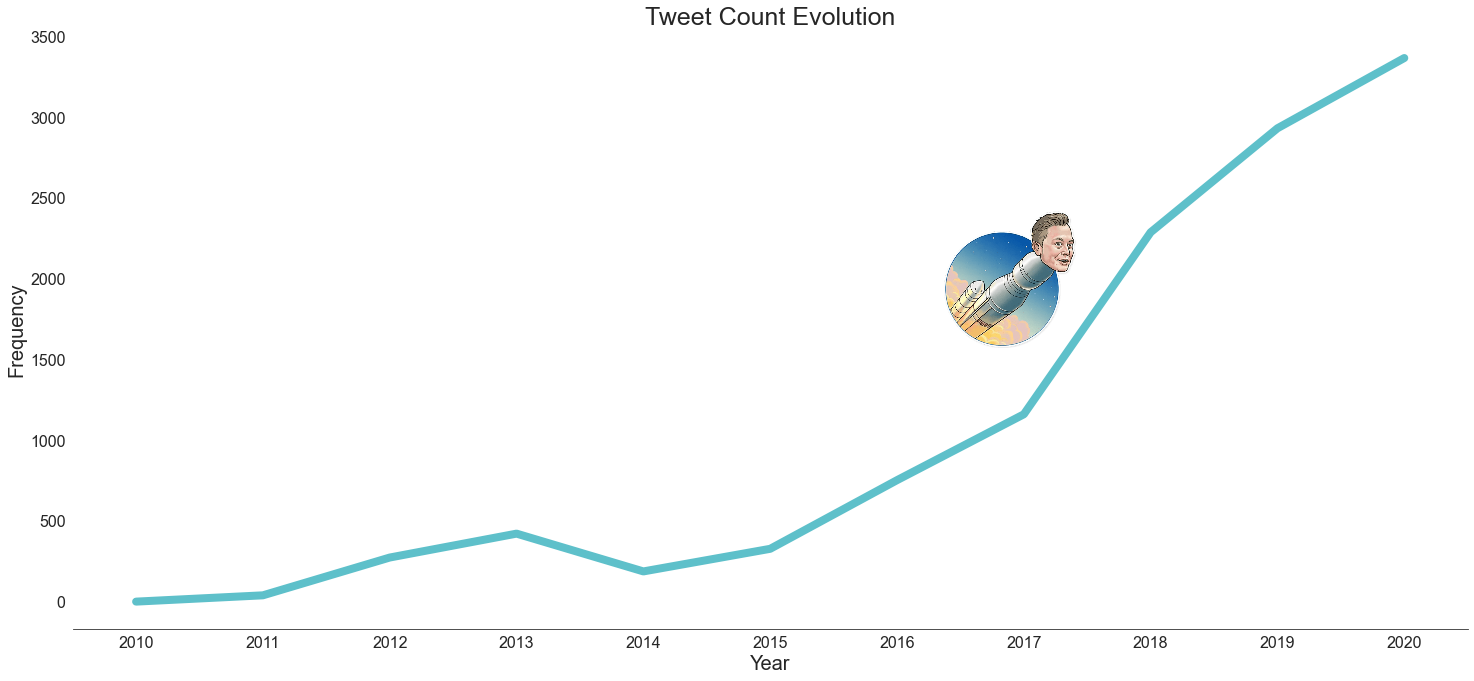

In [5]:
# Yearly evolution
date_count_df = tweets[tweets["year"]!="2021"].groupby("year")["tweet"].count().reset_index()

# Plot
plt.figure(figsize=(25, 11))
ax = sns.lineplot(data=date_count_df, x="year", y="tweet", lw=8, color=my_colors[3])
plt.title("Tweet Count Evolution", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Frequency", size=20)
sns.despine(left=True);

# Picture
path='elon_rocket.png'
offset_png(x=6.9, y=2000, path=path, ax=ax, zoom=0.27, offset=0)

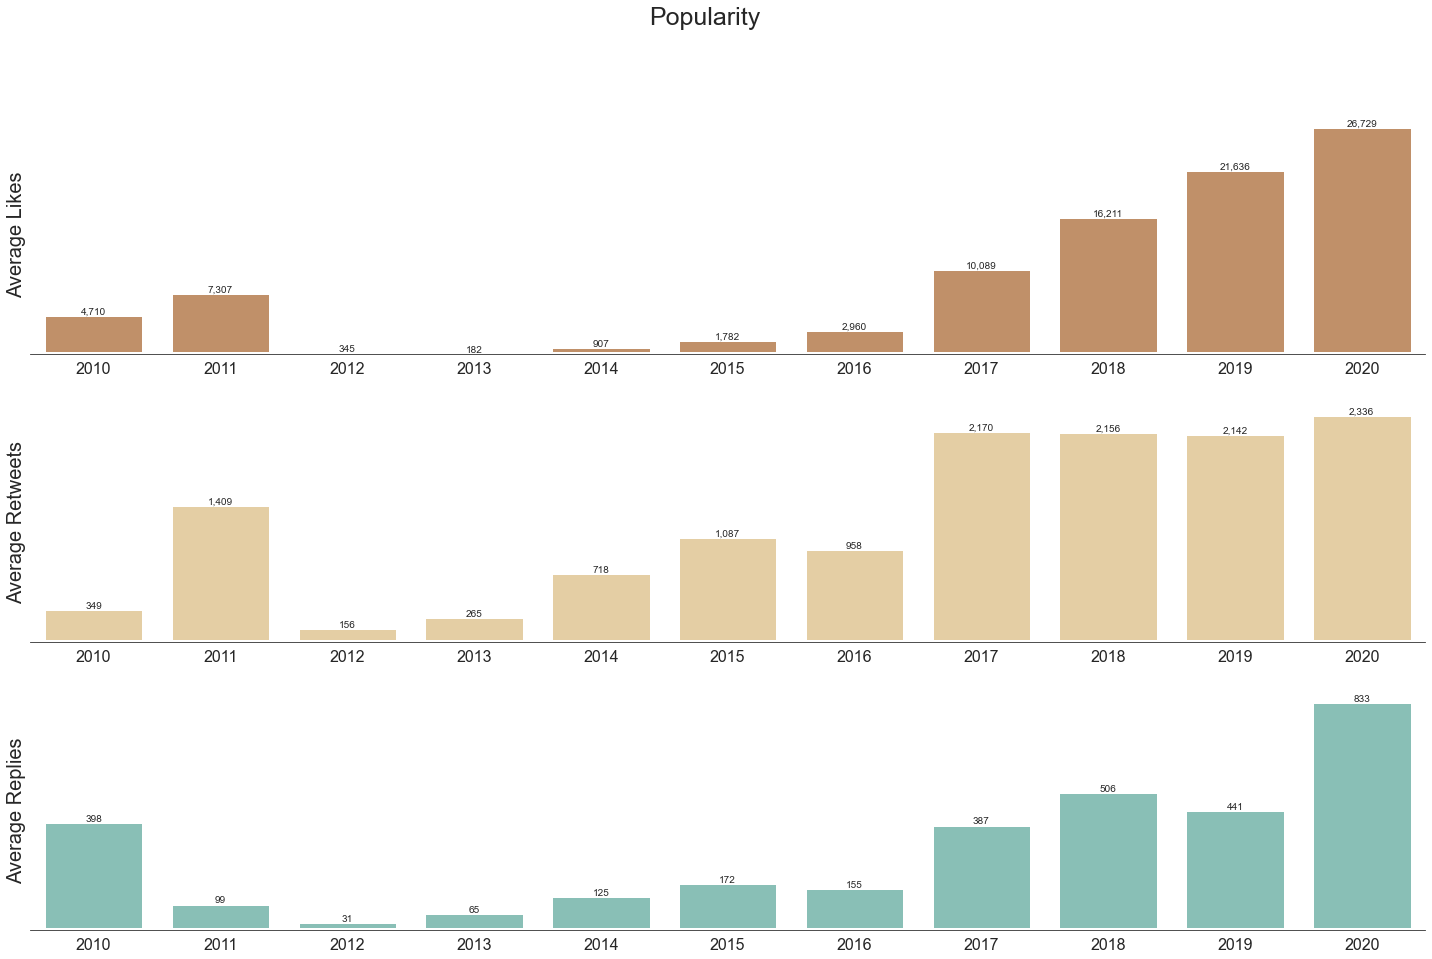

In [6]:
# Get Popularity Information
popularity = ["likes_count", "retweets_count", "replies_count"]
popularity_df = tweets[tweets["year"]!="2021"].groupby("year").agg({popularity[0] : 'sum',
                                                                    popularity[1] : 'sum',
                                                                    popularity[2] : 'sum',
                                                                    'tweet' : 'count'}).reset_index()
popularity_df["likes_count"] = popularity_df["likes_count"]/popularity_df["tweet"]
popularity_df["retweets_count"] = popularity_df["retweets_count"]/popularity_df["tweet"]
popularity_df["replies_count"] = popularity_df["replies_count"]/popularity_df["tweet"]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(25, 15))
axs = [ax1, ax2, ax3]
plt.suptitle("Popularity", size=25)
sns.barplot(data=popularity_df, x="year", y="likes_count", lw=5, color=my_colors[0], ax=ax1)
sns.barplot(data=popularity_df, x="year", y="retweets_count", lw=5, color=my_colors[1], ax=ax2)
sns.barplot(data=popularity_df, x="year", y="replies_count", lw=5, color=my_colors[2], ax=ax3)
names = ["Average Likes", "Average Retweets", "Average Replies"]
for ax, n in zip(axs, names):
    ax.set_xlabel("", size=20)
    ax.set_ylabel(n, size=20)
    ax.get_yaxis().set_ticks([])
#     ax.title.set_text(n)
    show_values_on_bars(axs=ax, h_v="v", space=0.4)
    sns.despine(left=True);


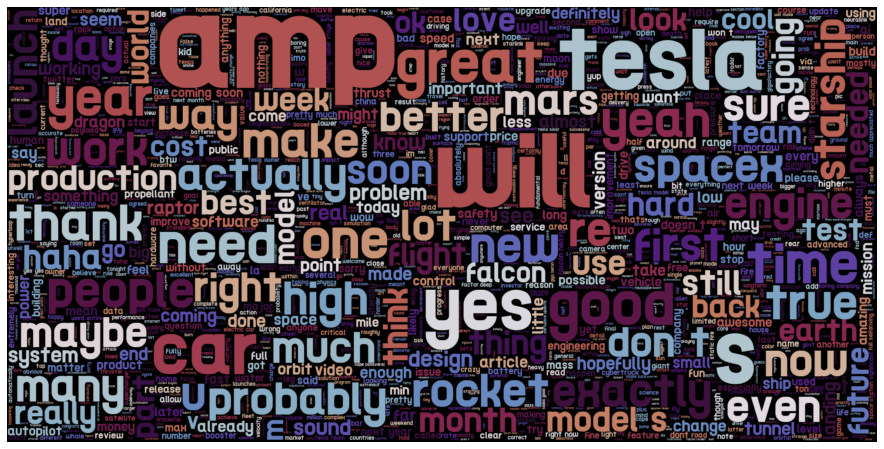

In [7]:
# Make worldcloud
all_tweets = " ".join(token for token in tweets["tweet"])
stopwords_wc = set(stopwords_wc)
font_path = "acetone_font.otf"

wordcloud = WordCloud(stopwords=stopwords_wc, font_path=font_path,
                      max_words=1500,
                      max_font_size=350, random_state=42,
                      width=2000, height=1000,
                      colormap = "twilight")
wordcloud.generate(all_tweets)

# Plot
plt.figure(figsize = (16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

In [8]:
# Retrieve only Bitcoin Information
bitcoin_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)

# Information
print(color.BOLD + "% of tweets about Bitcoin:" + color.END, "{:.3}%".format(bitcoin_tweets.shape[0]/tweets.shape[0]*100))

top = bitcoin_tweets.sort_values("likes_count", ascending=False)[:7]["tweet"]
print("\n", color.BOLD + "Most liked BITCOIN tweets:" + color.END)
for k, text in enumerate(top):
    print(f"{k+1}. {text}")

% of tweets about Bitcoin: 0.111%

 Most liked BITCOIN tweets:
1. you can now buy a tesla with bitcoin
2. btc bitcoin is an anagram of tbcthe boring company what a coincidence
3. bitcoin is my safe word
4. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
5. pay by bitcoin capability available outside us later this year
6. bitcoin is almost as bs as fiat money
7. bitcoin is not my safe word


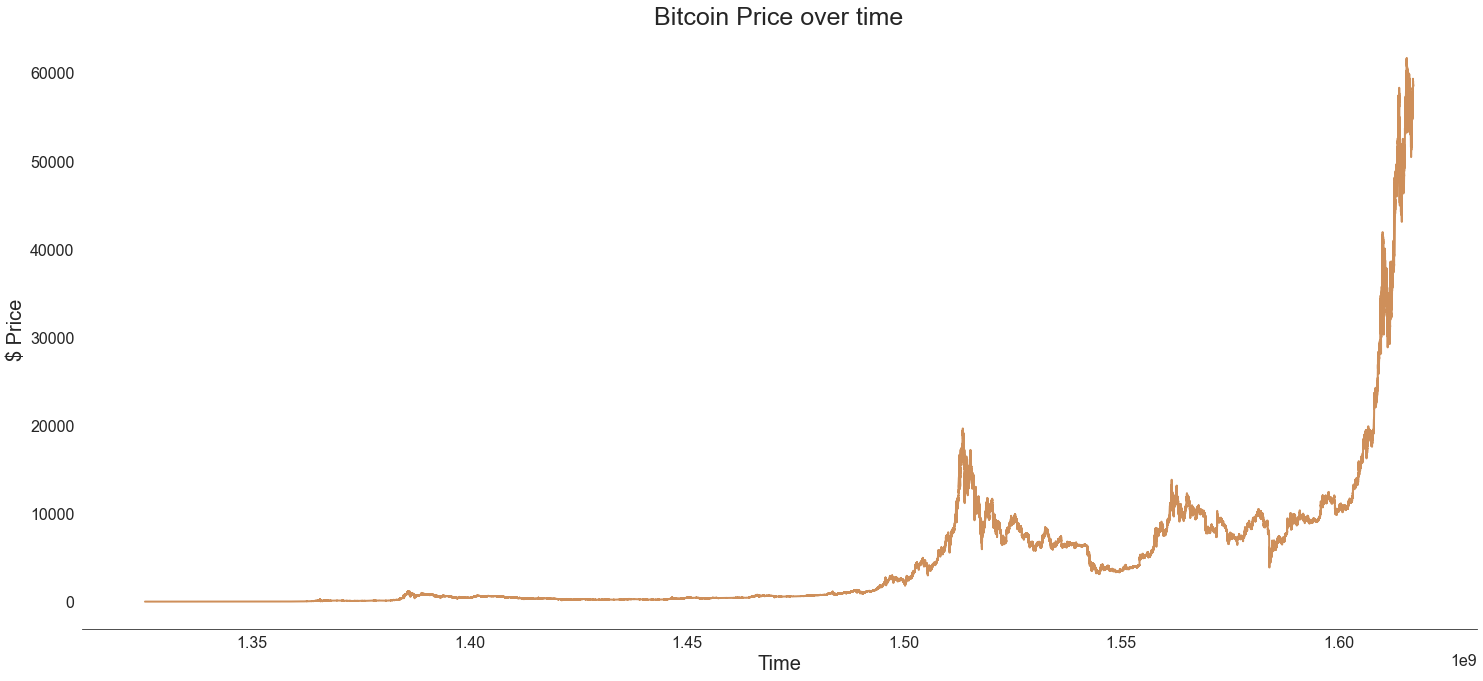

In [9]:
plt.figure(figsize = (25, 11))
plt.plot(bitcoin["Timestamp"].to_numpy(), bitcoin["Weighted_Price"].to_numpy(), color=my_colors[0], lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);

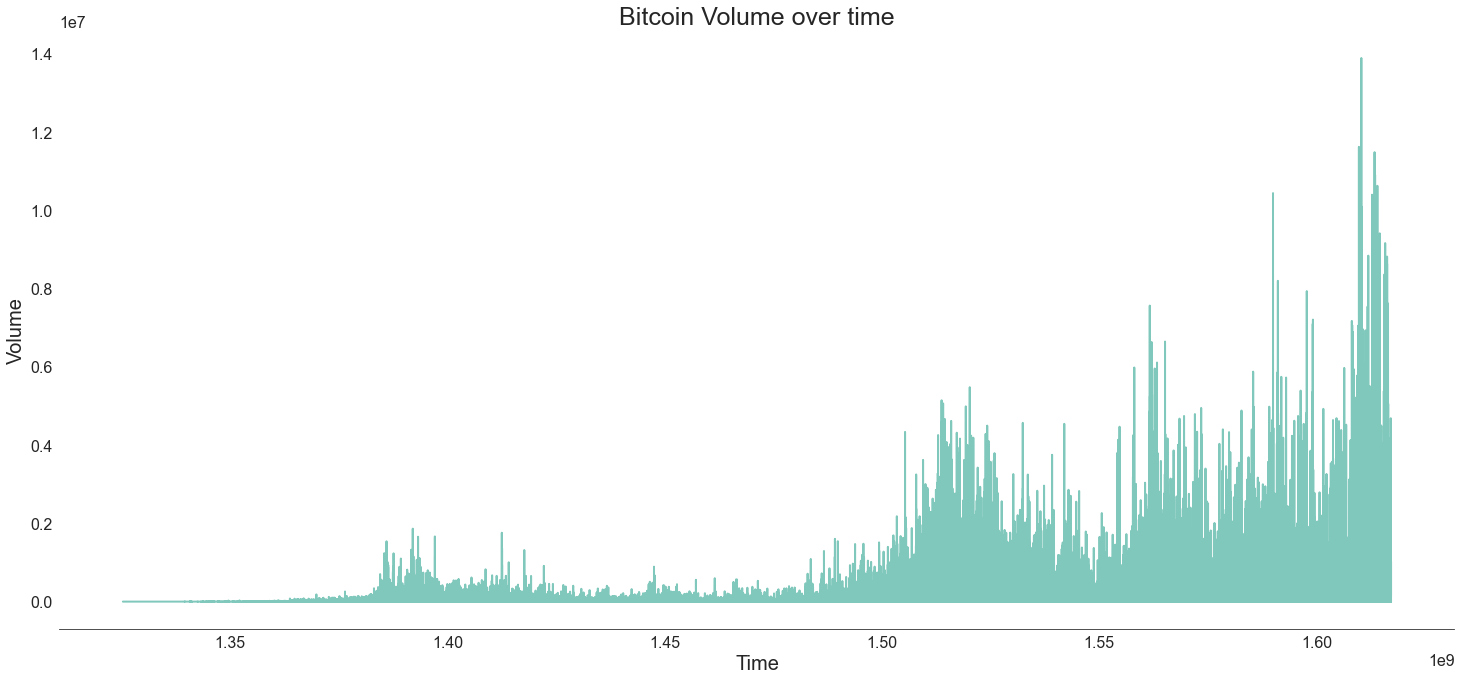

In [10]:
plt.figure(figsize = (25, 11))
plt.plot(bitcoin["Timestamp"].to_numpy(), bitcoin["Volume_(Currency)"].to_numpy(), color=my_colors[2], lw=2)
plt.title("Bitcoin Volume over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

1. pay by bitcoin capability available outside us later this year
2. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
3. you can now buy a tesla with bitcoin
4. btc bitcoin is an anagram of tbcthe boring company what a coincidence
5. to be clear i am not an investor i am an engineer i don’t even own any publicly traded stock besides tesla however when fiat currency has negative real interest only a fool wouldn’t look elsewhere bitcoin is almost as bs as fiat money the key word is “almost”
6. tesla’s action is not directly reflective of my opinion having some bitcoin which is simply a less dumb form of liquidity than cash is adventurous enough for an sampp500 company
7. bitcoin is almost as bs as fiat money
8. bitcoin is my safe word
9. toss a bitcoin to ur witcher
10. i still only own 025 bitcoins btw
11. pretty much although massive currency issuance by govt centra

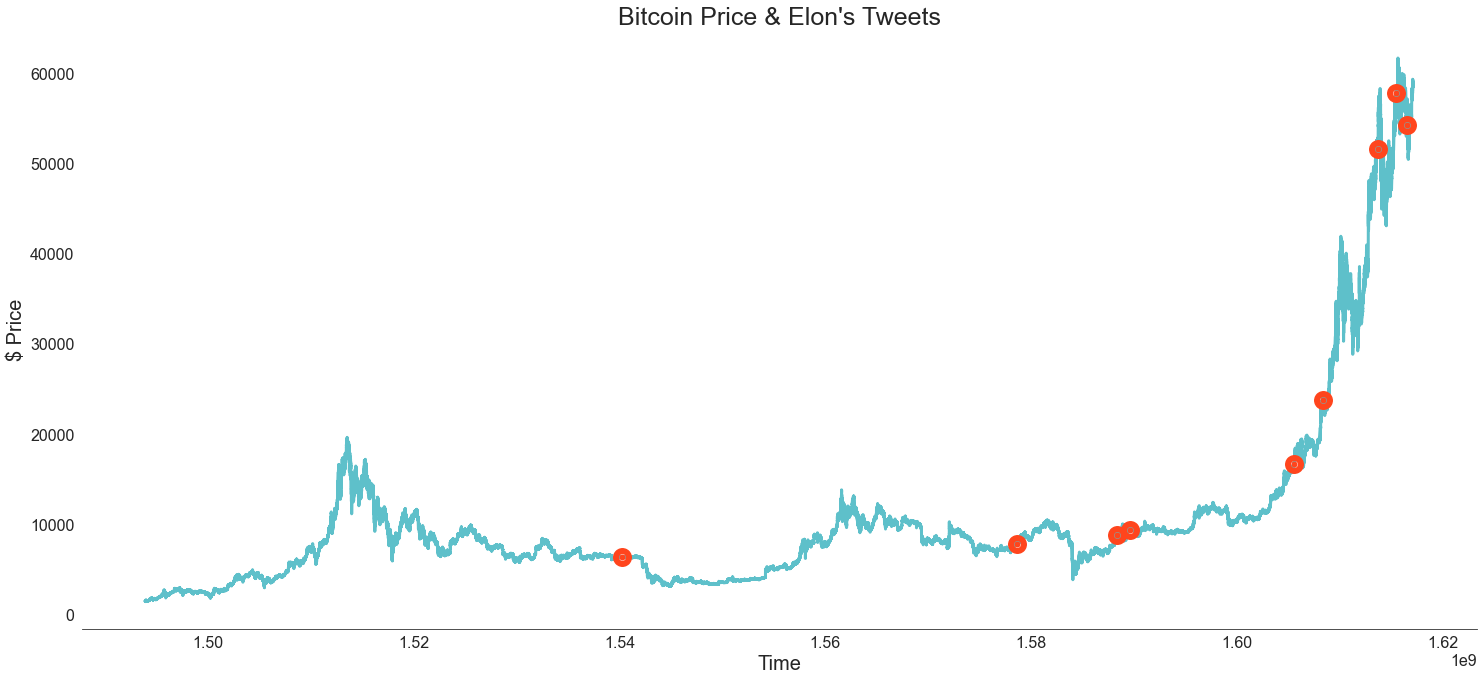

In [11]:
# Get bitcoin info
btc_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)
# Convert date to number
btc_tweets["date"] = btc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())
# Get only latest bitcoin data (as Elon never tweeted before 2018)
btc_prices = bitcoin.sort_values("Timestamp", ascending=False).head(2000000)
timestamps = btc_tweets["date"]

for k, tweet in enumerate(btc_tweets["tweet"]): print(color.BOLD + f"{k+1}." + color.END, tweet)

# Get intersection
x_values = btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Timestamp"]
y_values = btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Weighted_Price"]

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(btc_prices["Timestamp"].to_numpy(), btc_prices["Weighted_Price"].to_numpy(), color=my_colors[3], lw=3, zorder=1)
plt.title("Bitcoin Price & Elon's Tweets", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);

1. pay by bitcoin capability available outside us later this year
2. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
3. you can now buy a tesla with bitcoin


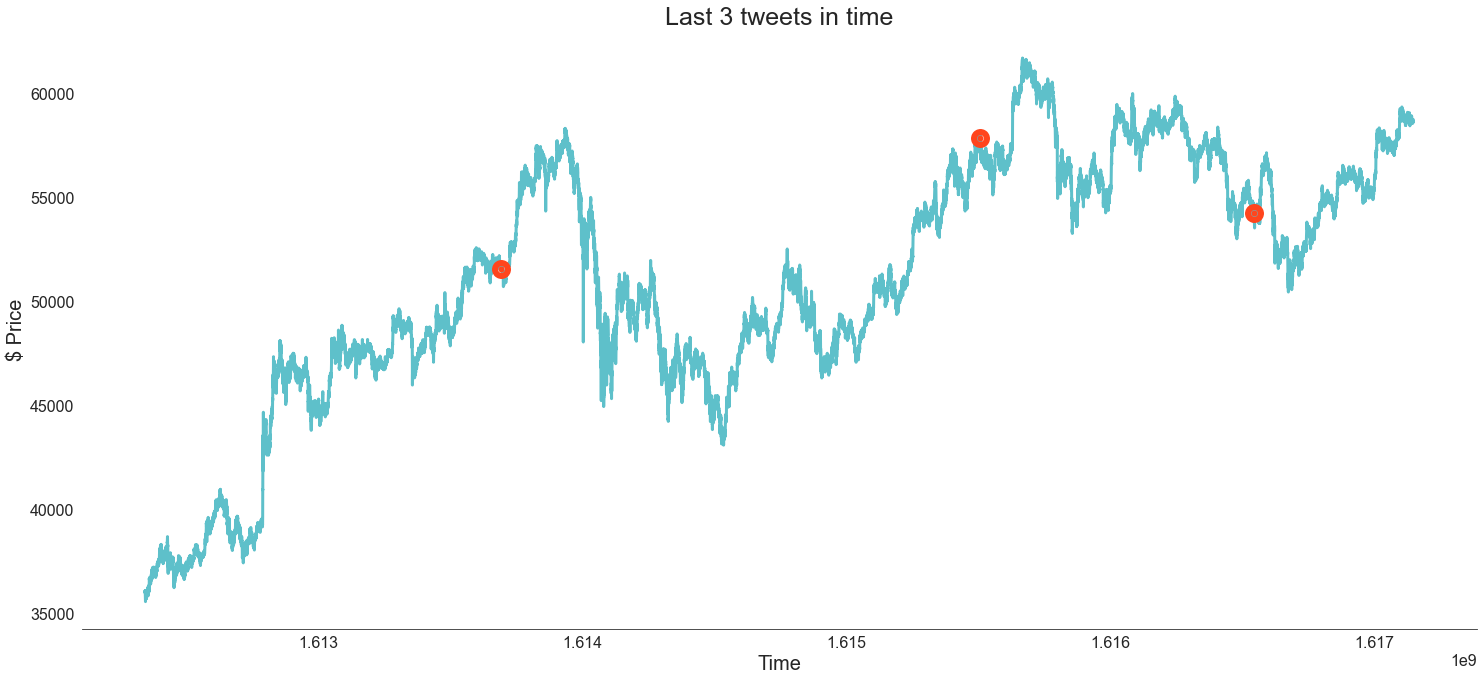

In [12]:
# Get bitcoin info
btc_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)
# Convert date to number
btc_tweets["date"] = btc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())
# Get only latest bitcoin data (as Elon never tweeted before 2018)
btc_prices = bitcoin.sort_values("Timestamp", ascending=False).head(80000)
timestamps = btc_tweets["date"]

for k, tweet in enumerate(btc_tweets["tweet"][:3]): print(color.BOLD + f"{k+1}." + color.END, tweet)

# Get intersection
x_values = btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Timestamp"]
y_values = btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Weighted_Price"]

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(btc_prices["Timestamp"].to_numpy(), btc_prices["Weighted_Price"].to_numpy(), color=my_colors[3], lw=3, zorder=1)
plt.title("Last 3 tweets in time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);